In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm

import os

import json
import matplotlib.pyplot as plt


In [ ]:
## dataloader

In [2]:
## train


for step, data in enumerate(dataloader) :

    data

    pred = model(x) 
    loss = criterion(pred, gt)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()




IndentationError: unexpected indent (3295619247.py, line 4)

dict_keys(['name', 'attributes', 'timestamp', 'labels', 'imgsize'])


In [18]:
categories = []

with open('data/label/det_train.json') as f :
    json_info = json.load(f)


for info in json_info :
    try :
        labels = info['labels']
    except :
        print(info['name'])
        continue
    for l in labels :
        categories.append(l['category'])
        

11ecaf4a-837e3550.jpg
272cd572-f7289b9d.jpg
282678b0-5f4e4eb3.jpg
31a83844-ba334636.jpg
321877a3-f277463d.jpg
48f20d4e-504d2377.jpg
49cf8611-8991f7a7.jpg
51a2ee54-e7f7d10f.jpg
57ea20aa-d836f65b.jpg
65c115f0-324deb97.jpg


In [2]:
from glob import glob

train_imgfiles = glob('data/images/train/*.jpg')

In [3]:
classes = ['traffic sign', 'traffic light', 'car', 'rider', 'motorcycle', 'pedestrian', 'bus', 'truck', 'bicycle', 'other vehicle', 'train', 'trailer', 'other person']

classes_dict = {c : i for i, c in enumerate(classes)}

In [69]:
class BDDDataset(Dataset) :
    def __init__(self, imgdir, jsonfile, num_grid, num_classes, numBox, transform = None ) :
        super().__init__()
        self.imgdir = imgdir
        self.imgfiles = glob(os.path.join(self.imgdir, '*.jpg'))
        
        with open(jsonfile, 'r') as f :
            json_infos = json.load(f)
        self.json_infos = json_infos

        ## make sure json information and imgfile are matched
        for info, imgfile in tqdm(zip(self.json_infos, self.imgfiles), desc = 'validate json and image matching...') :
            assert os.path.basename(imgfile) == info['name']

        self.num_grid = num_grid
        self.num_classes = num_classes
        self.numBox = numBox

        self.transform = transform
        

    def __getitem__(self, idx) :
        imgfile = self.imgfiles[idx]
        json_info = self.json_infos[idx]

        json_info = json_info['labels'] if 'labels' in json_info.keys() else []

        image = plt.imread(imgfile)
        
        
        bboxes = []
        labels = []
        for info in json_info :
            label = info['category']
            coord = info['box2d']
            x, y = coord['x'], coord['y']
            w, h = coord['w'], coord['h']
            label = classes_dict[label]
            
            bboxes.append([x,y,w,h])
            if x < 0 :
                print(x)
                raise 

            labels.append(label)


        try :
            if self.transform :
                transformed = self.transform(image = image, bboxes = bboxes, label = labels)
                image = transformed['image']
                bboxes = transformed['bboxes']
                labels = transformed['label']
        except :
            bboxes = np.array(bboxes)
            print(bboxes[bboxes < 0])
            raise

        H, W = image.shape[:2]
        label_grid = self.encode(bboxes, labels, H, W)

        return image, label_grid, json_info, bboxes, labels
        

    def __len__(self) :
        return len(self.imgfiles)


    def encode(self, bboxes, labels, H, W) :
        label_grid = np.zeros((self.num_grid, self.num_grid, self.numBox * 5 + self.num_classes ), np.float64)
        for bbox, label in zip(bboxes, labels) :

            x, y, w, h = bbox

            # x *= W
            # y *= H
            


            assert H == W, f'yolov1 takes only square image size. H = {H}, W = {W}'
            gridsize = 1 / self.num_grid

            grid_xidx = min(max(0, int(x // gridsize)), self.num_grid - 1) # there are cases center of bbox located at the endpoint
            grid_yidx = min(max(0, int(y // gridsize)), self.num_grid - 1) 

            ## normalize respect to the grid point
            grid_x0 = gridsize * grid_xidx
            grid_y0 = gridsize * grid_yidx

            normalized_x = (x - grid_x0) / gridsize
            normalized_y = (y - grid_y0) / gridsize

            # put into the grid
            for boxnum in range(self.numBox) : 
                boxnum *= 5
                label_grid[grid_yidx, grid_xidx, boxnum : boxnum + 5 ] = [normalized_x, normalized_y, w, h, 1] 
                label_grid[grid_yidx, grid_xidx, boxnum + label] = 1.0

        return label_grid
        


In [76]:
import albumentations as A

data_transform = A.Compose([
    A.geometric.resize.SmallestMaxSize(max_size = 446),
    A.RandomSizedBBoxSafeCrop(width = 446, height = 446, erosion_rate = 0.1),
], bbox_params = A.BboxParams(format = 'yolo', label_fields = ['label'], min_visibility = 0.8))


In [77]:
dataset = BDDDataset(imgdir = 'data/images/val', 
           jsonfile = 'data/label/yolo_det_val.json', 
           num_grid = 7, 
           num_classes = 13, 
           numBox = 2 , 
           transform = data_transform )


validate json and image matching...: 10000it [00:00, 588286.18it/s]


In [78]:
img, label_grid, json_info, before_bboxes, bboxes, labels = dataset.__getitem__(0)

[]


ValueError: Expected x_min for bbox (-0.00015846484375000094, 0.46781681944444453, 0.040783464843750006, 0.5596653805555556, 2) to be in the range [0.0, 1.0], got -0.00015846484375000094.

In [27]:
label_grid

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.97522545, 0.08319526, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [28]:
[b[0] for b in before_bboxes]

[0.7973928179687501,
 0.1910623375,
 0.6355747148437499,
 0.5224970042968751,
 0.5561278765625,
 0.49325277031250003,
 0.25247523203125,
 0.22664282421874998,
 0.17692762421875,
 0.19057493359375,
 0.06921135703125,
 0.2320042671875,
 0.02047096484375,
 0.5132363308593749,
 0.5127489265625,
 0.5619767230468751,
 0.5488168171875,
 0.5624641273437501,
 0.581472880078125,
 0.60828009609375,
 0.6614071234375001,
 0.718433382421875,
 0.8376815816084937,
 0.9699338066406249,
 0.47375661328124996,
 0.46449593828125,
 0.41624295,
 0.43622651093750003,
 0.45328564921875003,
 0.46059670781249995,
 0.48155507578125,
 0.41136891093750005,
 0.398209005078125,
 0.36409073046875]

##### visualize label_grid from Dataset

In [32]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # white

def visualize_gridbbox(img, label_grid, numBox = 2, color = BOX_COLOR, thickness = 2) :
    H, W = img.shape[:2]

    copy_img = img.copy()
    assert H == W, 'image size should be same.'
    num_grid, _, info_length = label_grid.shape

    gridratio = 1 / num_grid

    gridsize = H // num_grid

    for yidx in range(num_grid) :
        for xidx in range(num_grid) :
            
            for box_idx in range(numBox) : 

                x0, y0 = gridratio * xidx, gridratio * yidx
                x_center, y_center, w, h = label_grid[yidx, xidx, box_idx * 5 : box_idx * 5 + 4]
                x_center = int((x_center * gridsize + x0) * W)
                y_center = int((y_center * gridsize + y0) * H)

                xmin = int(x_center - w*W)
                ymin = int(y_center - h*H)
                xmax = int(x_center + w*W)
                ymax = int(y_center + h*H)

                cv2.rectangle(copy_img, (xmin, ymin), (xmax, ymax), color = color, thickness = thickness)
    
    return copy_img
    


    
    


In [33]:
## TODO : 값이 다 0? 
## visualize grid and from grid value

vis_img = visualize_gridbbox(img, label_grid)

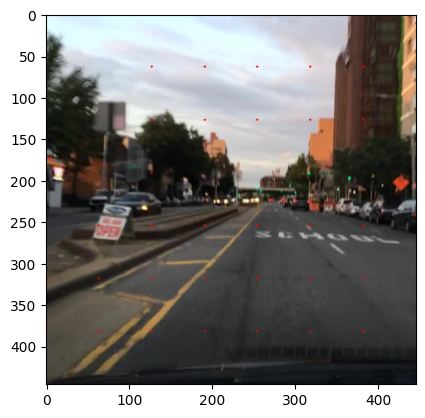

In [34]:
plt.imshow(vis_img)

In [78]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    img_h, img_w = img.shape[:2]

    x, y, w, h = bbox
    x_min, x_max, y_min, y_max = x - w, x + w, y - w, y + w
    x_min = int(img_w * x_min)
    x_max = int(img_w * x_max)
    y_min = int(img_h * y_min)
    y_max = int(img_h * y_max)



   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    # ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    # cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    # cv2.putText(
    #     img,
    #     text=class_name,
    #     org=(x_min, y_min - int(0.3 * text_height)),
    #     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #     fontScale=0.35, 
    #     color=TEXT_COLOR, 
    #     lineType=cv2.LINE_AA,
    # )
    return img


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

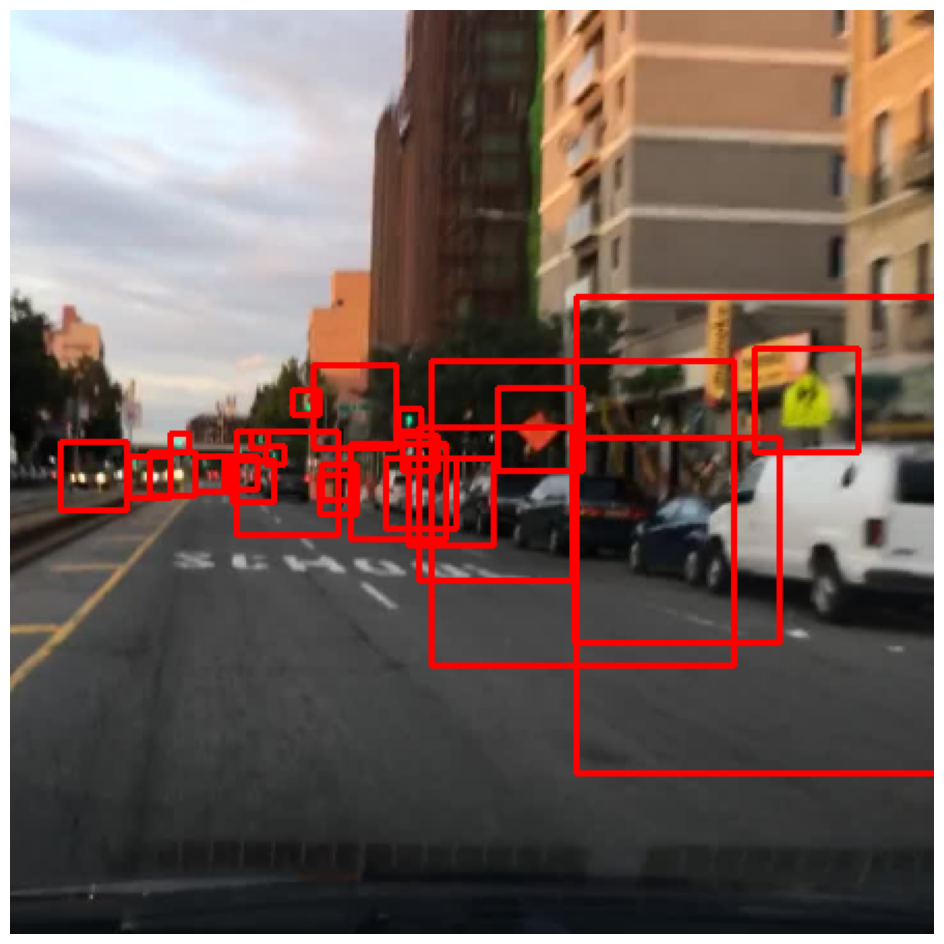

In [86]:
visualize(img, bboxes, labels)

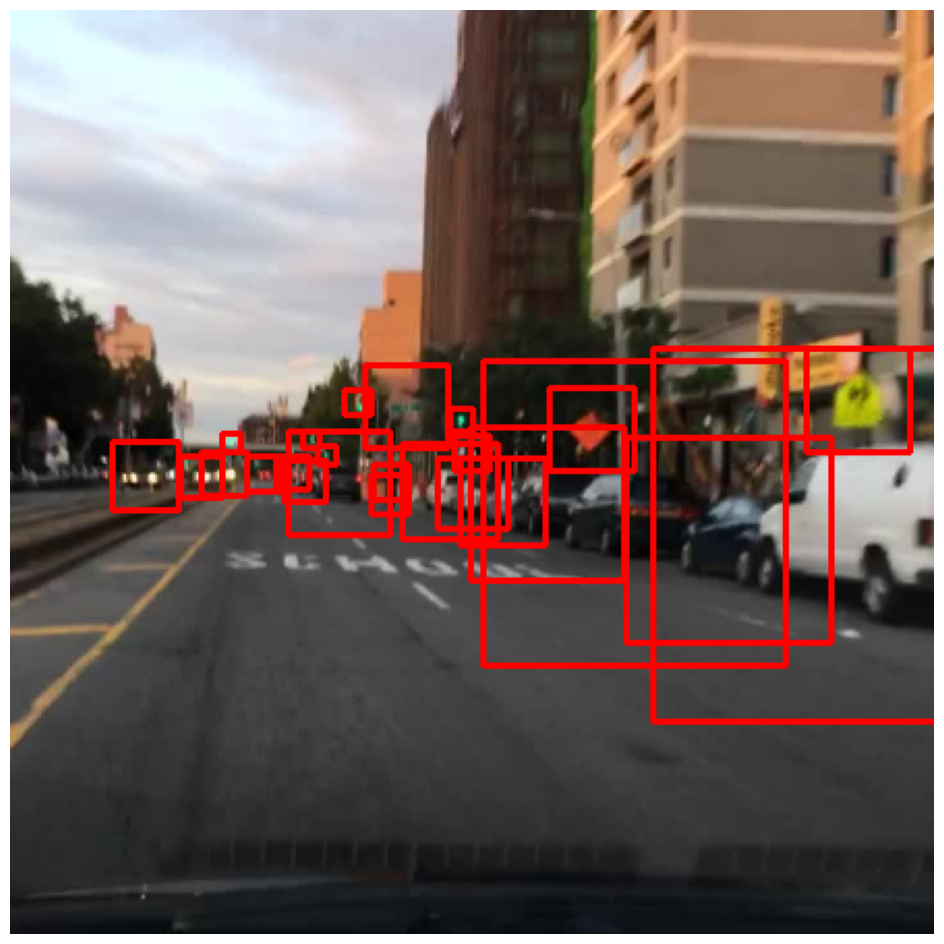

In [79]:
visualize(img, bboxes, labels)

In [53]:
class YOLO(nn.Module):
    def __init__(self, VGG16, num_grids = 7, numBox = 2, num_classes = 13):
        '''
        VGG16 : backbone network
        num_grids : # of grids to divde an image, make sure to be dividable with image size
        numBox : number of boxes per grid
        num_classes : # of classes. In BDD, there are 13 classes
        '''
        super().__init__()

        self.backbone = VGG16
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear((num_grids**2) * 1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(4096, (num_grids**2)*(numBox*5 + num_classes)) # 5 = len([x,y,w,h,pr(obj)])
        )

        # 가중치 초기화
        for m in self.conv.modules():
    	    if isinstance(m, nn.Conv2d) :
		        nn.init.normal_(m.weight, mean=0, std=0.01)
                
        for m in self.linear.modules():
        	if isinstance(m, nn.Linear) :
                 nn.init.normal_(m.weight, mean=0, std=0.01)
                

    # 정전파 
    def forward(self, x):
        out = self.backbone(x)
        out = self.conv(out)
        out = self.linear(out)
        out = torch.reshape(out, (-1 ,self.num_grids, self.num_grids, 
                                        self.numBox*5 + self.num_classes))
        return out

In [25]:
1470 / 7 / 7 / 30

1.0

[0.220347058984375,
 0.5182461013888889,
 0.023992875781249978,
 0.05545020000000002]

In [ ]:
def visualize_bbox

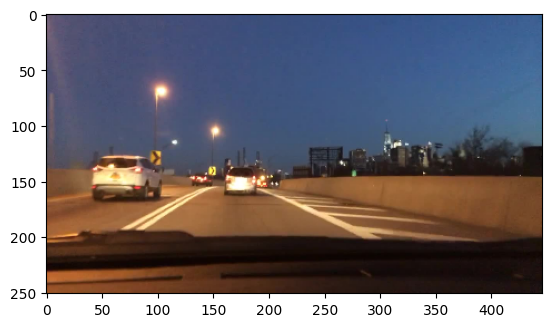

In [46]:
plt.imshow(transformed['image'])

In [48]:

print(transformed['bboxes'])
print(bboxes)

[(0.220347058984375, 0.5182461013888889, 0.023992875781249978, 0.05545020000000006), (0.3359137746752534, 0.5606776177220316, 0.015993183461993188, 0.03367823544406312), (0.6210280730468749, 0.57262995, 0.011996436718750059, 0.023459699999999972), (0.31331944960937497, 0.5940238495838146, 0.04438681796874999, 0.048918303610148484), (0.160964692578125, 0.5843598013888889, 0.14755618203124998, 0.16208520277777783), (0.43882834921875, 0.6099522006944444, 0.02370062187500005, 0.0341232013888888), (0.39069647343749997, 0.6003550513888889, 0.0695793375, 0.10450229999999994)]
([0.220347058984375, 0.5182461013888889, 0.023992875781249978, 0.05545020000000002], [0.3359137746752534, 0.5606776177220315, 0.015993183461993167, 0.03367823544406308], [0.6210280730468749, 0.57262995, 0.011996436718750036, 0.023459700000000003], [0.31331944960937497, 0.5940238495838146, 0.04438681796875001, 0.048918303610148525], [0.160964692578125, 0.5843598013888889, 0.14755618203124998, 0.16208520277777777], [0.4388